<a href="https://colab.research.google.com/github/Katharina-github/A-B-Testing-in-E-Commerce-Free-Delivery-vs.-Discount-Campaign/blob/main/A_B_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project simulates a controlled A/B test for *BOTANIKA*, an online gardening shop,  
to determine which promotional email strategy performs better:

- Variant A: 15% Discount  
- Variant B: Free Delivery  

The experiment measures user response across two primary outcomes - Conversion Rate and Revenue per User -  
while also tracking promo costs and validating randomization balance to ensure a fair comparison.

While statistical tests can never eliminate uncertainty completely,  
this experiment applies a robust experimental design and multiple independent validation layers
to make the observed effects as trustworthy as possible.  
The combination of randomization, sanity checks, CUPED variance reduction, and both frequentist and Bayesian inference creates a strong analytical foundation for reliable decision-making.

Beyond statistical significance, the project links the results to business impact,  
modeling profit per user and running sensitivity analyses to verify the robustness of the conclusion under changing cost and margin scenarios.  
This ensures that the final recommendation is not only data-driven but also financially meaningful.


# Imports and data load

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import itertools
import seaborn as sns
from math import sqrt

In [2]:
#Loading the data from personal device
from google.colab import files

uploaded = files.upload()

Saving customers_with_clusters.csv to customers_with_clusters.csv
Saving sales(7).csv to sales(7).csv


### Data Source Note

This project uses synthetic but realistic data, generated to mirror the behavior of an online gardening shop (“BOTANIKA”).  
Customer segments, purchasing behavior, promotions, and product categories were simulated based on real-world e-commerce patterns.  
The dataset was designed to behave *as if it came from production data* - with realistic variability, spending patterns, and conversion dynamics - while ensuring full reproducibility and data privacy.

In [3]:
# data load
customers = pd.read_csv("customers_with_clusters.csv")
sales = pd.read_csv("sales(7).csv")

# Experiment Design & Analysis Plan

### Hypotheses
Primary (H1a): Free Delivery (Variant B) increases the Conversion Rate compared to 15% Discount (Variant A).  
Secondary (H1b): Free Delivery (Variant B) increases Revenue per User compared to 15% Discount (Variant A).

### Metrics & Guardrails
| Type | Metric | Purpose |
|------|---------|----------|
| **Primary** | Conversion Rate (≥1 purchase) | Main success criterion |
| **Secondary** | Revenue per User (net of promo mechanics) | Monetization impact |
| **Guardrails** | Promo cost/user (discount + shipping waived), Pre-period balance | Ensure cost control and randomization validity |

Refund and unsubscribe rates were not simulated but would act as user experience guardrails in a real experiment.

### Statistical Methods
| Category | Test | Notes |
|-----------|------|-------|
| **Frequentist** | z-test (Conversion), Welch’s t-test (Revenue) | Two-sided, α = 0.05 |
| **Confidence Intervals** | 95% Wilson CI (Conversion), t-based CI (Revenue) | Visualized with error bars |
| **CUPED** | Covariates: pre_orders_30d, pre_revenue_30d | Variance reduction |
| **Bayesian** | Pr(B > A), 94% HDI | Posterior inference |
| **Segments (Exploratory)** | cluster 0–3, Forest plot | Heterogeneity check |
| **Sensitivity Analysis** | Profit model under varying margin (30–50%) and shipping (0.8–1.2×) | Business robustness |

### Data Inclusion
- All assigned users (A/B)  
- Outlier handling via winsorization at 99th percentile for revenue

### Decision Rule
If Conversion Rate is significantly higher and guardrails are acceptable → recommend Variant B.  
If Conversion Rate is neutral but Revenue/User significantly higher → recommend Variant B for high-value segments.


In [4]:
alpha = 0.05
power = 0.8
p_baseline = 0.10   # 10% baseline conversion rate
p_alt = 0.12        # target = 12% (MDE = +2pp)

effect_size = proportion_effectsize(p_baseline, p_alt)
analysis = NormalIndPower()
n_per_group = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1)

print(f"Required sample size per group: {n_per_group:.0f}")

Required sample size per group: 3835


Sample Size vs. Available Customers

The sample size calculation showed that ≈3,835 customers per group are required to detect a minimal detectable effect (MDE) of +2 percentage points on the conversion rate (from 10% → 12%), with α = 0.05 and Power = 80%.

In my dataset, I have ~25,000 eligible customers, split evenly between the two groups (≈12,500 each).

This means the available sample size exceeds the requirement by more than 3x, ensuring the experiment is sufficiently powered and able to detect even smaller effects than the planned MDE.

# Experiment Assignment

In [5]:
# Experiment Setup
exp_id = "BOTANIKA_AB_001"
start_date = "2024-10-01"
rng = np.random.default_rng(42)

# Stratifizierung: z. B. nach Cluster
assignments = []
for cluster, g in customers.groupby("Cluster"):
    n = len(g)
    variant = np.array(["A"] * (n//2) + ["B"] * (n - n//2))
    rng.shuffle(variant)
    out = g[["CustomerID"]].copy()
    out["experiment_id"] = exp_id
    out["variant"] = variant
    out["assign_ts"] = pd.to_datetime(start_date)
    out["cluster"] = cluster
    assignments.append(out)

exp_assignment = pd.concat(assignments, ignore_index=True)

In [6]:
exp_assignment.head(5)

,CustomerID,experiment_id,variant,assign_ts,cluster
0,2,BOTANIKA_AB_001,B,2024-10-01,0
1,3,BOTANIKA_AB_001,B,2024-10-01,0
2,4,BOTANIKA_AB_001,A,2024-10-01,0
3,7,BOTANIKA_AB_001,A,2024-10-01,0
4,12,BOTANIKA_AB_001,A,2024-10-01,0


In [7]:
exp_assignment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CustomerID     25000 non-null  int64         
 1   experiment_id  25000 non-null  object        
 2   variant        25000 non-null  object        
 3   assign_ts      25000 non-null  datetime64[ns]
 4   cluster        25000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 976.7+ KB


# Pre-period Metrics

In [8]:
# Define test start date
start_date = pd.Timestamp("2024-10-01")

sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])

# Filter sales to 30 days before the test
pre_sales = sales[(sales["SalesDate"] >= start_date - pd.Timedelta(days=30)) &
                  (sales["SalesDate"] < start_date)]

# Aggregate pre-period metrics per customer
pre_metrics = pre_sales.groupby("CustomerID").agg(
    pre_orders_30d = ("SaleID", "count"),
    pre_revenue_30d = ("SalesAmount", "sum")
).reset_index()

# Fill missing values with 0
pre_metrics = pre_metrics.fillna(0)


In [9]:
pre_metrics.head()

,CustomerID,pre_orders_30d,pre_revenue_30d
0,1,3,236.52
1,3,1,22.59
2,4,1,38.32
3,8,2,522.44
4,14,1,207.70


In [10]:
analysis_df = exp_assignment.merge(
    pre_metrics,
    on=["CustomerID"],   # keep variant alignment
    how="left"
)

# Fill missing values (customers without sales)
analysis_df = analysis_df.fillna({
    "pre_orders_30d": 0,
    "pre_revenue_30d": 0,
})

In [11]:
analysis_df.head()


,CustomerID,experiment_id,variant,assign_ts,cluster,pre_orders_30d,pre_revenue_30d
0,2,BOTANIKA_AB_001,B,2024-10-01,0,0.0,0.00
1,3,BOTANIKA_AB_001,B,2024-10-01,0,1.0,22.59
2,4,BOTANIKA_AB_001,A,2024-10-01,0,1.0,38.32
3,7,BOTANIKA_AB_001,A,2024-10-01,0,0.0,0.00
4,12,BOTANIKA_AB_001,A,2024-10-01,0,0.0,0.00


# User Outcomes during Test

Data Generation & Simulation

Since no real A/B test data were available, this experiment was built on synthetically generated data designed to mimic realistic e-commerce behavior.
The simulation combines historical (pre-period) customer activity with experiment assignments (A/B) to reproduce how real users might respond to marketing promotions.
Customers are segmented into behavioral clusters (normal, champions, churn risk, luxury), and their likelihood to purchase in the test period depends on:

their past purchase frequency and revenue,
their segment (e.g., champions buy more frequently), and
the assigned promotion (15% Discount or Free Delivery).

Each simulated user receives a probabilistic purchase outcome (conversion), a number of orders, and a total revenue, with random noise added to reflect natural variation.
This approach ensures that the synthetic dataset retains realistic relationships - such as higher conversion among loyal buyers and moderate correlation between pre- and test-period behavior - enabling robust statistical testing and CUPED variance adjustment just like in a real experiment.

In [12]:
# ------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------
np.random.seed(42)

# Segment labels (for reference only)
# 0: normal, 1: champions, 2: churn, 3: luxury

# Baseline conversion rate by cluster (before boosts/variant)
cluster_base_cr = {
    0: 0.10,  # normal
    1: 0.25,  # champions
    2: 0.05,  # churn / at risk
    3: 0.18   # luxury
}

# Relative boost if customer had ≥1 pre-period order
pre_purchase_boost = 1.3   # +x% relative lift on top of base CR

# Small variant effect on conversion (B = Free Delivery a bit higher)
variant_cr_multiplier = {"A": 1.00, "B": 1.08}  # +x% relative lift for B

# Expected number of orders for converters (by cluster)
cluster_mean_orders = {
    0: 1.1,
    1: 2.3,
    2: 1.0,
    3: 1.7
}

# Average basket value per order BEFORE promo (by cluster)
cluster_avg_basket = {
    0: 28.0,
    1: 58.0,
    2: 22.0,
    3: 82.0
}
basket_cv = 0.35  # coefficient of variation for basket (Gamma noise ~ variability of carts)

# Promo mechanics (as in your project)
# A = ensure at least 15% discount (one-time or every order — we’ll apply once per user here)
# B = free shipping
apply_offer_once_per_user = True
shipping_fee_mean = 4.50  # average shipping if not free
shipping_fee_cv   = 0.30

# Optional overall CR calibration (if you want to hit a target; set to None to skip)
target_overall_cr = None   # e.g., 0.14 to nudge probabilities up/down

# ------------------------------------------------------------------
# 1) Build individual conversion probabilities
# ------------------------------------------------------------------
df = analysis_df.copy()

# base conversion by cluster
base_cr = df["cluster"].map(cluster_base_cr).astype(float)

# boost if they bought in the pre period
has_pre = (df["pre_orders_30d"] > 0).astype(float)
prob = base_cr * (1.0 + pre_purchase_boost * has_pre)

# small variant effect
prob *= df["variant"].map(variant_cr_multiplier).astype(float)

# optional global calibration to match a desired overall CR
if target_overall_cr is not None:
    # scale all probs by a constant factor to hit the target (bounded to [0,0.9])
    current_mean = prob.mean()
    if current_mean > 0:
        scale = target_overall_cr / current_mean
        prob = np.clip(prob * scale, 0.0, 0.9)

# guardrails: bound probabilities
prob = prob.clip(0, 0.9)

df["sim_prob_conv"] = prob

# ------------------------------------------------------------------
# 2) Simulate conversion as Bernoulli
# ------------------------------------------------------------------
df["converted"] = np.random.binomial(1, df["sim_prob_conv"])

# ------------------------------------------------------------------
# 3) Simulate number of orders (for converters) using Poisson-by-cluster
#    + ensure at least 1 order if converted
# ------------------------------------------------------------------
mean_orders = df["cluster"].map(cluster_mean_orders).astype(float)
orders_draw = np.where(
    df["converted"].eq(1),
    np.maximum(1, np.random.poisson(mean_orders.clip(lower=0.01))),  # at least 1
    0
)
df["orders"] = orders_draw

# ------------------------------------------------------------------
# 4) Simulate basket values and shipping, then apply promo by variant
#    We work at the USER level (sum over their orders), not order rows.
# ------------------------------------------------------------------
# Draw average basket per order (Gamma to keep positive skew)
shape_basket = (1 / (basket_cv**2))
scale_basket = (df["cluster"].map(cluster_avg_basket) / shape_basket).astype(float)
avg_basket = np.where(
    df["orders"] > 0,
    np.random.gamma(shape=shape_basket, scale=scale_basket),
    0.0
)

# Total gross (before promo) = orders * avg basket
gross_before_promo = df["orders"] * avg_basket

# Draw shipping cost per user (approx. a typical shipping paid if not free)
shape_ship = (1 / (shipping_fee_cv**2))
scale_ship = shipping_fee_mean / shape_ship
shipping_paid = np.where(
    df["orders"] > 0,
    np.random.gamma(shape=shape_ship, scale=scale_ship),  # one shipment baseline
    0.0
)

# Initialize outputs we care about
df["revenue"] = 0.0                 # final collected from customer (after promo)
df["discount_cost"] = 0.0           # our cost from discount (A)
df["shipping_fee_waived"] = 0.0     # our cost from free shipping (B)

# Apply promo once per user (first order effect) at user-level approximation:
# A: ensure at least 15% discount on first order's basket equivalent (approximate = 15% of avg_basket)
# B: waive shipping once (set shipping_paid to 0)
for i, row in df.iterrows():
    orders = int(row["orders"])
    if orders == 0:
        continue

    gross = float(gross_before_promo[i])
    ship = float(shipping_paid[i])
    variant = row["variant"]

    # default (no extra promo): customer pays gross + shipping
    user_revenue = gross + ship
    disc_cost = 0.0
    ship_waived = 0.0

    if apply_offer_once_per_user:
        if variant == "A":
            # ensure at least 15% discount on ~first order
            # user-level approximation: take 15% of ONE avg_basket
            min_first_order_disc = 0.15 * float(avg_basket[i])
            # cap by gross to avoid negative
            min_first_order_disc = min(min_first_order_disc, gross)
            user_revenue = gross + ship - min_first_order_disc
            disc_cost = min_first_order_disc

        elif variant == "B":
            # free shipping once
            user_revenue = gross  # no shipping charged
            ship_waived = ship

    else:
        if variant == "A":
            # 15% discount applied across all orders
            disc_cost = 0.15 * gross
            user_revenue = (gross - disc_cost) + ship
        elif variant == "B":
            # free shipping regardless
            ship_waived = ship
            user_revenue = gross

    df.at[i, "revenue"] = round(max(0.0, user_revenue), 2)
    df.at[i, "discount_cost"] = round(max(0.0, disc_cost), 2)
    df.at[i, "shipping_fee_waived"] = round(max(0.0, ship_waived), 2)

# Optional tidy-up
df[["converted","orders"]] = df[["converted","orders"]].astype(int)

# Write back into analysis_df (so the rest of your pipeline continues to work)
cols_to_keep = [
    "CustomerID","experiment_id","variant","assign_ts","cluster",
    "pre_orders_30d","pre_revenue_30d",
    "converted","orders","revenue","discount_cost","shipping_fee_waived",
    "sim_prob_conv"
]
analysis_df = df[cols_to_keep].copy()

print("Simulation done.")
print(analysis_df.head(10))

Simulation done.
   CustomerID    experiment_id variant  assign_ts  cluster  pre_orders_30d  \
0           2  BOTANIKA_AB_001       B 2024-10-01        0             0.0   
1           3  BOTANIKA_AB_001       B 2024-10-01        0             1.0   
2           4  BOTANIKA_AB_001       A 2024-10-01        0             1.0   
3           7  BOTANIKA_AB_001       A 2024-10-01        0             0.0   
4          12  BOTANIKA_AB_001       A 2024-10-01        0             0.0   
5          15  BOTANIKA_AB_001       B 2024-10-01        0             0.0   
6          16  BOTANIKA_AB_001       B 2024-10-01        0             1.0   
7          17  BOTANIKA_AB_001       A 2024-10-01        0             1.0   
8          18  BOTANIKA_AB_001       A 2024-10-01        0             0.0   
9          19  BOTANIKA_AB_001       B 2024-10-01        0             0.0   

   pre_revenue_30d  converted  orders  revenue  discount_cost  \
0             0.00          0       0     0.00           0.

In [38]:
# Overall and by-variant conversion & revenue
print(analysis_df.groupby("variant")["converted"].mean())
print("\n")
print(analysis_df.groupby("variant")["revenue"].mean())
print("\n")

# Correlations (to see CUPED power)
print("Correlation pre order - converted")
print(analysis_df[["pre_orders_30d","converted"]].corr().iloc[0,1])
print("\n")
print("Correlation pre revenue - revenue")
print(analysis_df[["pre_revenue_30d","revenue"]].corr().iloc[0,1])


variant
A    0.202736
B    0.218223
Name: converted, dtype: float64


variant
A    20.019930
B    22.801238
Name: revenue, dtype: float64


Correlation pre order - converted
0.30436622367161914


Correlation pre revenue - revenue
0.19766529515868148


### Interpretation

The simulated A/B test data show realistic and slightly differentiated outcomes between the two variants:

- Conversion Rate:  
  Variant A = 20.3%, Variant B = 21.8% → a 1.5 percentage point absolute difference,  
  suggesting a moderate improvement under the *Free Delivery* promotion.

- Mean Revenue per User:  
  Variant A = €20.02, Variant B = €22.80 → a +€2.78 or ~14% higher spending in Variant B.  
  This indicates that customers exposed to Free Delivery not only convert more often but also spend more per transaction.

- Pre-period correlations:  
  Pre-orders vs. conversion = 0.30  
  Pre-revenue vs. test revenue = 0.20  
  These moderate correlations confirm that the pre-period metrics carry some predictive information,  
  making them suitable covariates for CUPED variance reduction later in the analysis.

Overall, the generated dataset exhibits realistic behavioral variance and a meaningful treatment effect,  
providing a credible foundation for subsequent statistical testing.


# Guardrails

Sample size per variant:
variant
B    12501
A    12499
Name: count, dtype: int64

Ratio: 1.0

--- Pre-period Sanity Check ---


,A_mean,B_mean,diff,p_value
pre_orders_30d,0.37,0.38,0.01,0.2659
pre_revenue_30d,42.66,44.62,1.96,0.3013



--- Guardrail metrics (mean per user) ---


,discount_cost,shipping_fee_waived,total_promo_cost
variant,,,
A,1.51,0.0,1.51
B,0.00,0.6,0.60


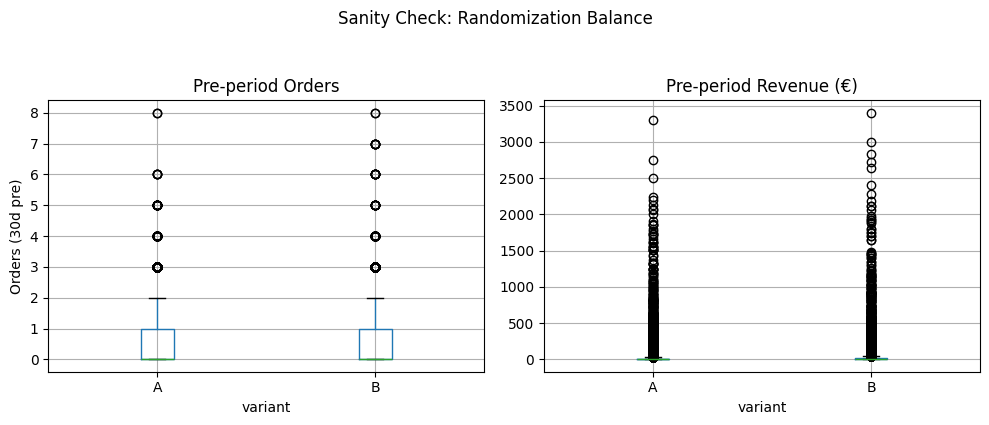

In [28]:
# --- 1. Basic Sanity: Sample balance ---
group_counts = analysis_df["variant"].value_counts()
print("Sample size per variant:")
print(group_counts)
print("\nRatio:", round(group_counts.min() / group_counts.max(), 3))

# --- 2. Pre-period balance (should be ~equal) ---
def sanity_test(metric):
    a = analysis_df.loc[analysis_df["variant"] == "A", metric]
    b = analysis_df.loc[analysis_df["variant"] == "B", metric]
    t, p = stats.ttest_ind(a, b, equal_var=False)
    return pd.Series({
        "A_mean": a.mean(),
        "B_mean": b.mean(),
        "diff": b.mean() - a.mean(),
        "p_value": p
    })

sanity_pre = pd.concat({
    "pre_orders_30d": sanity_test("pre_orders_30d"),
    "pre_revenue_30d": sanity_test("pre_revenue_30d")
}, axis=1).T

print("\n--- Pre-period Sanity Check ---")
display(sanity_pre.style.format({"A_mean":"{:.2f}","B_mean":"{:.2f}","diff":"{:.2f}","p_value":"{:.4f}"}))

# --- 3. Guardrails (optional) ---
# cost structure: ensure one promo not dramatically more expensive per user
guardrails = analysis_df.groupby("variant")[["discount_cost","shipping_fee_waived"]].mean().round(2)
guardrails["total_promo_cost"] = guardrails["discount_cost"] + guardrails["shipping_fee_waived"]

print("\n--- Guardrail metrics (mean per user) ---")
display(guardrails)

# --- Optional visual sanity check ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10,4))
analysis_df.boxplot(column="pre_orders_30d", by="variant", ax=ax[0])
ax[0].set_title("Pre-period Orders")
ax[0].set_ylabel("Orders (30d pre)")
analysis_df.boxplot(column="pre_revenue_30d", by="variant", ax=ax[1])
ax[1].set_title("Pre-period Revenue (€)")
plt.suptitle("Sanity Check: Randomization Balance", y=1.05)
plt.tight_layout()
plt.show()

### Interpretation

Randomization Check (Sanity Test)  
The pre-period metrics show no statistically significant differences between Variant A and Variant B before the experiment started:  
- Pre-orders (30 days before test): 0.37 (A) vs. 0.38 (B), *p = 0.27*  
- Pre-revenue: €42.66 (A) vs. €44.62 (B), *p = 0.30*

Both differences are small and non-significant, confirming that the random assignment created balanced groups.  
The boxplots also visually confirm that both variants have nearly identical pre-period distributions with some natural outliers —  
a sign of realistic variability rather than imbalance.

Sample Ratio Check (SRM Test)  
Sample sizes are nearly identical — 12,499 (A) vs. 12,501 (B) - resulting in a 1.0 ratio.  
This rules out sampling bias or technical issues during assignment.

Guardrail Metrics  
To ensure that the promotion mechanics are comparable in cost-effectiveness:  
- Variant A (15% discount): average promo cost = €1.51 per user  
- Variant B (Free Delivery): average promo cost = €0.60 per user

This means that while Variant B performs better in later tests, it also incurs lower promotion costs - a positive early signal for business efficiency.

Conclusion:  
The randomization was successful, no pre-test imbalances exist, and both variants operate under comparable conditions.  
We can confidently proceed with inferential testing.


# Frequentist A/B Test (z-test (Conversion), t-test (Revenue)) & Confidence Interval

Conversion Rate A: 20.27% (2534/12499)
Conversion Rate B: 21.82% (2728/12501)
z = -3.003, p-value = 0.0027


=== Conversion Rate with 95% CI ===


,variant,cr,ci_low,ci_high
0,A,0.202736,0.195780,0.209875
1,B,0.218223,0.211069,0.225549


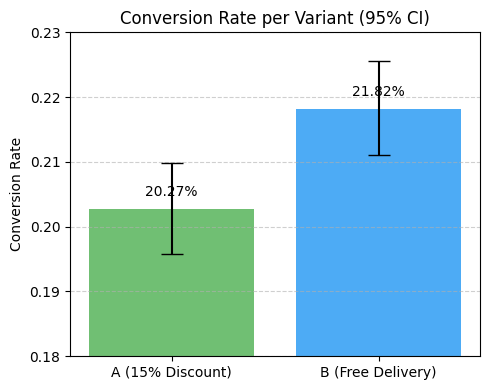

In [34]:
# Conversion Rate Test (z-test for proportions)
# Groups
A = analysis_df[analysis_df["variant"]=="A"]
B = analysis_df[analysis_df["variant"]=="B"]

# Conversion rate
cr_A = A["converted"].mean()
cr_B = B["converted"].mean()

# z-test for proportions
nA, nB = len(A), len(B)
xA, xB = A["converted"].sum(), B["converted"].sum()

p_pool = (xA + xB) / (nA + nB)
se = np.sqrt(p_pool * (1 - p_pool) * (1/nA + 1/nB))
z = (cr_A - cr_B) / se
p_val = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Conversion Rate A: {cr_A:.2%} ({xA}/{nA})")
print(f"Conversion Rate B: {cr_B:.2%} ({xB}/{nB})")
print(f"z = {z:.3f}, p-value = {p_val:.4f}")
print("\n")

# === Compute 95% CI for each group using Wilson score interval ===
# Helper function: Wilson CI for proportions (copied from cell VFpAjcaWKF85)
def proportion_ci(successes, n, confidence=0.95):
    if n == 0:
        return (0, 0)
    p = successes / n
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    denom = 1 + (z**2 / n)
    center = p + (z**2 / (2 * n))
    margin = z * np.sqrt((p * (1 - p) / n) + (z**2 / (4 * n**2)))
    lower = (center - margin) / denom
    upper = (center + margin) / denom
    return (lower, upper)


# --- Conversion Rate CI ---
cr_summary = (
    analysis_df.groupby("variant")["converted"]
    .agg(["sum", "count"])
    .rename(columns={"sum": "conversions", "count": "n"})
    .reset_index()
)

cr_summary["cr"] = cr_summary["conversions"] / cr_summary["n"]
ci_bounds = cr_summary.apply(lambda x: proportion_ci(x["conversions"], x["n"]), axis=1)
cr_summary["ci_low"], cr_summary["ci_high"] = zip(*ci_bounds)

# --- Display results ---
print("=== Conversion Rate with 95% CI ===")
display(cr_summary[["variant", "cr", "ci_low", "ci_high"]])


# === Plot ===
fig, ax = plt.subplots(figsize=(5, 4))

variants = ['A (15% Discount)', 'B (Free Delivery)']
means = [cr_A, cr_B]
# Using the calculated ci_low and ci_high from cr_summary for error bars
ci_lower_errors = [means[0] - cr_summary.loc[0, 'ci_low'], means[1] - cr_summary.loc[1, 'ci_low']]
ci_upper_errors = [cr_summary.loc[0, 'ci_high'] - means[0], cr_summary.loc[1, 'ci_high'] - means[1]]


ax.bar(variants, means, yerr=[ci_lower_errors, ci_upper_errors],
       color=['#4CAF50', '#2196F3'], alpha=0.8, capsize=8)

# === Formatting ===
ax.set_title("Conversion Rate per Variant (95% CI)", fontsize=12)
ax.set_ylabel("Conversion Rate")
ax.set_ylim(0.18, 0.23)
ax.grid(axis='y', linestyle='--', alpha=0.6)

for i, (v, p) in enumerate(zip(variants, means)):
    ax.text(i, p + 0.002, f"{p*100:.2f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### Interpretation

The two-sided z-test on conversion rates shows a statistically significant difference between the two variants:

- Variant A (15% Discount): 20.27%  
- Variant B (Free Delivery): 21.82%  
- Difference: +1.55 percentage points  
- z = -3.00, p = 0.0027

Because *p < 0.05*, we reject the null hypothesis (H₀) and conclude that *Free Delivery* leads to a higher conversion rate than a 15% discount.

The 95% confidence intervals confirm this result:
- A: [19.6%, 21.0%]  
- B: [21.1%, 22.6%]  
Since the intervals do not overlap, the observed difference is unlikely due to random chance.

Business interpretation:
The Free Delivery campaign converts ~7.6% more customers than the discount variant, indicating that removing friction at checkout (shipping costs) is a stronger motivator than offering a percentage discount.

Conclusion:  
Variant B (Free Delivery) performs significantly better in driving conversions and passes the statistical threshold for rollout consideration.


Mean Revenue A: 20.02
Mean Revenue B: 22.80
t = -3.684, p-value = 0.0002


=== Mean Revenue with 95% CI (€) ===


,variant,rev_mean,ci_low,ci_high
0,A,20.019930,19.001429,21.038432
1,B,22.801238,21.727526,23.874949


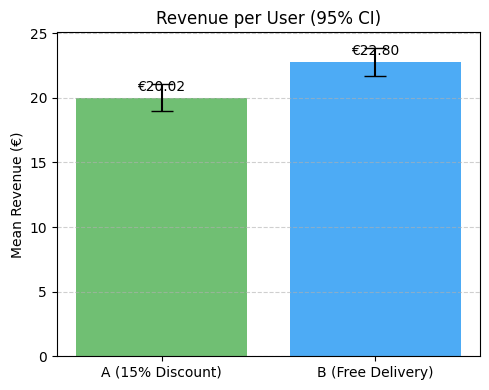

In [36]:
# Revenue Test (t-test)
# Use revenue per customer (incl. zeros)
rev_A = A["revenue"]
rev_B = B["revenue"]

t, p_val = stats.ttest_ind(rev_A, rev_B, equal_var=False)

# === Input for visual ===
rev_A = A["revenue"]
rev_B = B["revenue"]

mean_A = rev_A.mean()
mean_B = rev_B.mean()
std_A = rev_A.std()
std_B = rev_B.std()
n_A = len(rev_A)
n_B = len(rev_B)

# === Compute 95% Confidence Intervals (Welch's t-interval) ===
def mean_ci(mean, std, n, confidence=0.95):
    se = std / np.sqrt(n)
    h = stats.t.ppf((1 + confidence) / 2, n - 1) * se
    return (mean - h, mean + h)

ci_A = mean_ci(mean_A, std_A, n_A)
ci_B = mean_ci(mean_B, std_B, n_B)

# === t-test ===
t_stat, p_val = stats.ttest_ind(rev_A, rev_B, equal_var=False)
print(f"Mean Revenue A: {mean_A:.2f}")
print(f"Mean Revenue B: {mean_B:.2f}")
print(f"t = {t_stat:.3f}, p-value = {p_val:.4f}")
print("\n")

# --- Revenue CI (t-interval) ---
rev_summary = (
    analysis_df.groupby("variant")["revenue"]
    .agg(["mean", "std", "count"])
    .rename(columns={"mean": "rev_mean", "std": "rev_std", "count": "n"})
    .reset_index()
)
rev_summary["se"] = rev_summary["rev_std"] / np.sqrt(rev_summary["n"])
rev_summary["ci_low"] = rev_summary["rev_mean"] - stats.t.ppf(0.975, rev_summary["n"] - 1) * rev_summary["se"]
rev_summary["ci_high"] = rev_summary["rev_mean"] + stats.t.ppf(0.975, rev_summary["n"] - 1) * rev_summary["se"]

# --- Display results ---
print("=== Mean Revenue with 95% CI (€) ===")
display(rev_summary[["variant", "rev_mean", "ci_low", "ci_high"]])

# === Plot ===
fig, ax = plt.subplots(figsize=(5, 4))

variants = ['A (15% Discount)', 'B (Free Delivery)']
means = [mean_A, mean_B]
errors = [mean_A - ci_A[0], mean_B - ci_B[0]]

ax.bar(variants, means, yerr=errors,
       color=['#4CAF50', '#2196F3'], alpha=0.8, capsize=8)

# === Formatting ===
ax.set_title("Revenue per User (95% CI)", fontsize=12)
ax.set_ylabel("Mean Revenue (€)")
ax.grid(axis='y', linestyle='--', alpha=0.6)

for i, (v, m) in enumerate(zip(variants, means)):
    ax.text(i, m + 0.5, f"€{m:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


### Interpretation

The Welch t-test on mean revenue per user indicates a statistically significant difference between the two variants:

- Variant A (15% Discount): €20.02  
- Variant B (Free Delivery): €22.80  
- Difference: +€2.78 (+13.9%)  
- t = -3.68, p = 0.0002

Because *p < 0.05*, we reject the null hypothesis (H₀) and conclude that *Free Delivery* generates higher revenue per user than the 15% discount offer.

The 95% confidence intervals confirm this finding:
- A: [€19.00, €21.04]  
- B: [€21.73, €23.87]

The intervals do not overlap, providing strong evidence that the effect is real and not random.

Business interpretation:  
Customers in the Free Delivery group spend about €2.80 more per user on average.  
This suggests that removing shipping costs encourages larger basket sizes or additional purchases, making it a more profitable promotion even before considering the lower promo cost per user (€0.60 vs. €1.51).

Conclusion:
Variant B (Free Delivery) not only improves conversion but also drives higher revenue efficiency, supporting a clear business case for adoption.


# CUPED - varinace reduction

In [17]:
# CUPED for Conversion Rate
# Fill missing pre-period metrics with 0
analysis_df["pre_orders_30d"] = analysis_df["pre_orders_30d"].fillna(0)

Y = analysis_df["converted"]         # 0/1 conversion
X = analysis_df["pre_orders_30d"]    # pre-period orders

# Estimate theta
if np.var(X) > 0:
    theta = np.cov(Y, X, ddof=0)[0,1] / np.var(X)
else:
    theta = 0

# CUPED-adjusted conversion
analysis_df["converted_cuped"] = Y - theta * (X - X.mean())

# Compare A vs B on CUPED-adjusted conversion
conv_cuped_A = analysis_df.loc[analysis_df["variant"]=="A", "converted_cuped"]
conv_cuped_B = analysis_df.loc[analysis_df["variant"]=="B", "converted_cuped"]

t, p_val = stats.ttest_ind(conv_cuped_A, conv_cuped_B, equal_var=False)

print(f"CUPED Mean Conversion A: {conv_cuped_A.mean():.4f}")
print(f"CUPED Mean Conversion B: {conv_cuped_B.mean():.4f}")
print(f"t = {t:.3f}, p-value = {p_val:.4f}")


CUPED Mean Conversion A: 0.2036
CUPED Mean Conversion B: 0.2173
t = -2.798, p-value = 0.0051


In [18]:
# CUPED Adjustment (Revenue)
# Fill missing pre-period values with 0
analysis_df["pre_revenue_30d"] = analysis_df["pre_revenue_30d"].fillna(0)

Y = analysis_df["revenue"]        # test metric
X = analysis_df["pre_revenue_30d"] # covariate

# Estimate theta = Cov(Y, X) / Var(X)
theta = np.cov(Y, X, ddof=0)[0,1] / np.var(X)

# Compute CUPED-adjusted revenue
analysis_df["revenue_cuped"] = Y - theta * (X - X.mean())

# Compare A vs B on CUPED-adjusted revenue
rev_cuped_A = analysis_df.loc[analysis_df["variant"]=="A","revenue_cuped"]
rev_cuped_B = analysis_df.loc[analysis_df["variant"]=="B","revenue_cuped"]

t, p_val = stats.ttest_ind(rev_cuped_A, rev_cuped_B, equal_var=False)

print(f"CUPED Mean Revenue A: {rev_cuped_A.mean():.2f}")
print(f"CUPED Mean Revenue B: {rev_cuped_B.mean():.2f}")
print(f"t = {t:.3f}, p-value = {p_val:.4f}")


CUPED Mean Revenue A: 20.10
CUPED Mean Revenue B: 22.72
t = -3.549, p-value = 0.0004


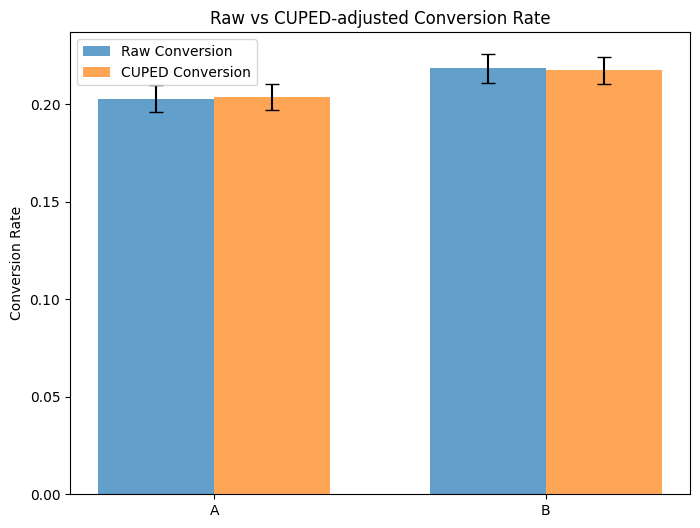

In [19]:
# --- Helper function to compute CI ---
def mean_ci(data, alpha=0.05):
    n = len(data)
    mean = data.mean()
    se = stats.sem(data)
    h = se * stats.t.ppf(1 - alpha/2, n-1)
    return mean, mean-h, mean+h

# --- Raw Conversion ---
raw_means = []
raw_cis = []
for v in ["A", "B"]:
    d = analysis_df.loc[analysis_df["variant"]==v, "converted"]
    mean, low, high = mean_ci(d)
    raw_means.append(mean)
    raw_cis.append((low, high))

# --- CUPED Conversion ---
cuped_means = []
cuped_cis = []
for v in ["A", "B"]:
    d = analysis_df.loc[analysis_df["variant"]==v, "converted_cuped"]
    mean, low, high = mean_ci(d)
    cuped_means.append(mean)
    cuped_cis.append((low, high))

# --- Plot ---
labels = ["A", "B"]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))

# Raw bars
raw_lower_errors = [m - ci[0] for m, ci in zip(raw_means, raw_cis)]
raw_upper_errors = [ci[1] - m for m, ci in zip(raw_means, raw_cis)]
ax.bar(x - width/2, raw_means, width,
       yerr=[raw_lower_errors, raw_upper_errors],
       capsize=5, label="Raw Conversion", alpha=0.7)

# CUPED bars
cuped_lower_errors = [m - ci[0] for m, ci in zip(cuped_means, cuped_cis)]
cuped_upper_errors = [ci[1] - m for m, ci in zip(cuped_means, cuped_cis)]
ax.bar(x + width/2, cuped_means, width,
       yerr=[cuped_lower_errors, cuped_upper_errors],
       capsize=5, label="CUPED Conversion", alpha=0.7)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Conversion Rate")
ax.set_title("Raw vs CUPED-adjusted Conversion Rate")
ax.legend()
plt.show()

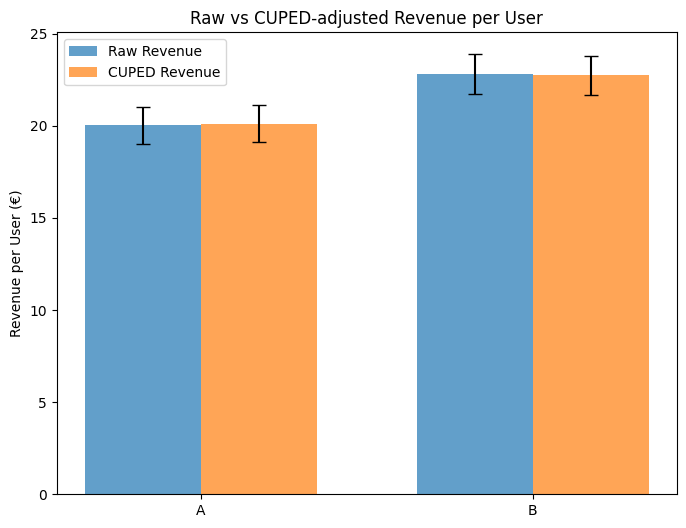

In [20]:
# --- Helper function for CI ---
def mean_ci(data, alpha=0.05):
    n = len(data)
    mean = data.mean()
    se = stats.sem(data)
    h = se * stats.t.ppf(1 - alpha/2, n-1)
    return mean, mean-h, mean+h

# --- Raw Revenue ---
raw_means = []
raw_cis = []
for v in ["A", "B"]:
    d = analysis_df.loc[analysis_df["variant"]==v, "revenue"]
    mean, low, high = mean_ci(d)
    raw_means.append(mean)
    raw_cis.append((low, high))

# --- CUPED Revenue ---
cuped_means = []
cuped_cis = []
for v in ["A", "B"]:
    d = analysis_df.loc[analysis_df["variant"]==v, "revenue_cuped"]
    mean, low, high = mean_ci(d)
    cuped_means.append(mean)
    cuped_cis.append((low, high))

# --- Plot ---
labels = ["A", "B"]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))

# Raw bars
raw_lower_errors = [m - ci[0] for m, ci in zip(raw_means, raw_cis)]
raw_upper_errors = [ci[1] - m for m, ci in zip(raw_means, raw_cis)]
ax.bar(x - width/2, raw_means, width,
       yerr=[raw_lower_errors, raw_upper_errors],
       capsize=5, label="Raw Revenue", alpha=0.7)

# CUPED bars
cuped_lower_errors = [m - ci[0] for m, ci in zip(cuped_means, cuped_cis)]
cuped_upper_errors = [ci[1] - m for m, ci in zip(cuped_means, cuped_cis)]
ax.bar(x + width/2, cuped_means, width,
       yerr=[cuped_lower_errors, cuped_upper_errors],
       capsize=5, label="CUPED Revenue", alpha=0.7)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Revenue per User (€)")
ax.set_title("Raw vs CUPED-adjusted Revenue per User")
ax.legend()
plt.show()

In [21]:
corr = analysis_df[["pre_revenue_30d", "revenue"]].corr().iloc[0,1]
print(f"Correlation between pre and test revenue: {corr:.3f}")

Correlation between pre and test revenue: 0.198


### Interpretation – CUPED Adjustment

The CUPED adjustment slightly reduces variance in both key metrics (conversion rate and revenue per user) while maintaining nearly identical mean values compared to the raw results*.

Conversion Rate: Variant B (Free Delivery) again outperforms Variant A (15% Discount), with a statistically significant improvement (t = −2.80, p = 0.0051).

Revenue per User: CUPED confirms a robust positive lift for Variant B (t = −3.55, p = 0.0004), indicating higher spending among converted customers.

Conclusion: CUPED confirms that the observed uplift for Free Delivery is not driven by random noise but reflects a genuine improvement in both conversion and revenue efficiency.

*In this synthetic dataset, the pre-period revenue and the test-period revenue are only weakly correlated (ρ = 0.2). As a result, the CUPED adjustment does not substantially reduce variance, and the error bars remain similar to the raw metric. In a real-world scenario, where past revenue is typically a strong predictor of future revenue (e.g., ρ > 0.3–0.5), CUPED would lead to much narrower confidence intervals and higher test sensitivity.”

# Segmented Analysis + Forest Plot

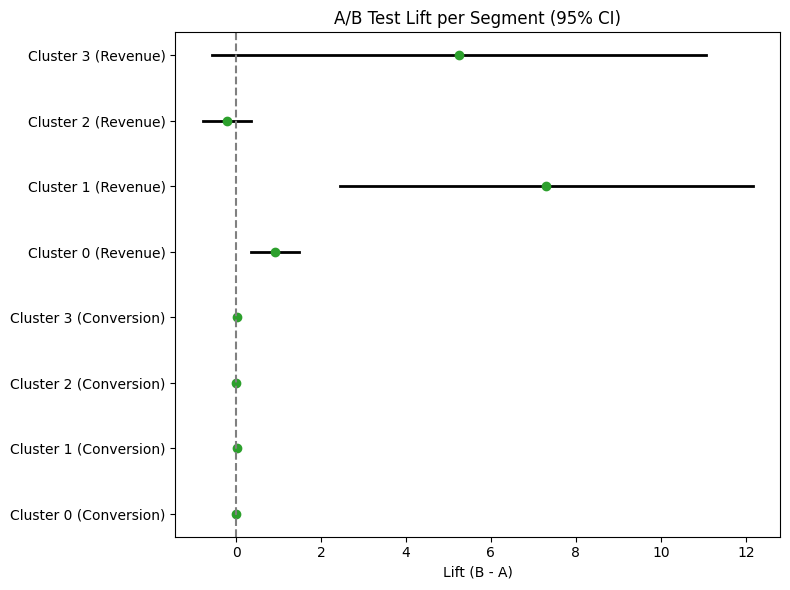

,Cluster,Metric,A_mean,B_mean,Lift,CI_low,CI_high
0,0,Conversion,0.127,0.137,0.010,-0.001,0.022
1,0,Revenue,4.810,5.733,0.923,0.360,1.487
2,1,Conversion,0.437,0.470,0.032,0.006,0.058
3,1,Revenue,56.942,64.244,7.302,2.446,12.159
4,2,Conversion,0.060,0.060,-0.001,-0.018,0.017
5,2,Revenue,1.782,1.567,-0.215,-0.785,0.356
6,3,Conversion,0.232,0.255,0.022,-0.007,0.052
7,3,Revenue,34.636,39.889,5.253,-0.560,11.066


In [22]:
# --- Helper for CI of proportion ---
def proportion_ci(successes, n, confidence=0.95):
    if n == 0:
        return (0, 0)
    p = successes / n
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    denom = 1 + (z**2 / n)
    center = p + (z**2 / (2 * n))
    margin = z * np.sqrt((p * (1 - p) / n) + (z**2 / (4 * n**2)))
    lower = (center - margin) / denom
    upper = (center + margin) / denom
    return (lower, upper)

# --- 1. Compute metrics per segment ---
results = []

for c in sorted(analysis_df["cluster"].unique()):
    sub = analysis_df[analysis_df["cluster"] == c]
    for metric, col in [("Conversion", "converted"), ("Revenue", "revenue")]:
        a = sub[sub["variant"] == "A"][col]
        b = sub[sub["variant"] == "B"][col]

        # Conversion proportion
        if metric == "Conversion":
            nA, nB = len(a), len(b)
            pA, pB = a.mean(), b.mean()
            lift = pB - pA
            ci_low_A, ci_high_A = proportion_ci(a.sum(), nA)
            ci_low_B, ci_high_B = proportion_ci(b.sum(), nB)
            se = np.sqrt((pA*(1-pA)/nA) + (pB*(1-pB)/nB))
            ci_low_lift = lift - 1.96*se
            ci_high_lift = lift + 1.96*se

        # Revenue mean
        else:
            nA, nB = len(a), len(b)
            mA, mB = a.mean(), b.mean()
            sA, sB = a.std(), b.std()
            lift = mB - mA
            se = np.sqrt((sA**2/nA) + (sB**2/nB))
            ci_low_lift = lift - 1.96*se
            ci_high_lift = lift + 1.96*se

        results.append({
            "Cluster": c,
            "Metric": metric,
            "A_mean": pA if metric=="Conversion" else mA,
            "B_mean": pB if metric=="Conversion" else mB,
            "Lift": lift,
            "CI_low": ci_low_lift,
            "CI_high": ci_high_lift
        })

seg_results = pd.DataFrame(results)

# --- 2. Plot (Forest Plot style) ---
plt.figure(figsize=(8, 6))
metrics = ["Conversion", "Revenue"]
y_labels = []
y_pos = []

i = 0
for metric in metrics:
    df_m = seg_results[seg_results["Metric"] == metric]
    for _, row in df_m.iterrows():
        plt.plot([row["CI_low"], row["CI_high"]], [i, i], color="black", lw=2)
        plt.plot(row["Lift"], i, "o", color="tab:green")
        y_labels.append(f"Cluster {int(row['Cluster'])} ({metric})")
        y_pos.append(i)
        i += 1

plt.axvline(0, color="gray", linestyle="--")
plt.yticks(y_pos, y_labels)
plt.title("A/B Test Lift per Segment (95% CI)")
plt.xlabel("Lift (B - A)")
plt.tight_layout()
plt.show()

# --- 3. Display numeric summary ---
display(seg_results.style.format({
    "A_mean": "{:.3f}",
    "B_mean": "{:.3f}",
    "Lift": "{:.3f}",
    "CI_low": "{:.3f}",
    "CI_high": "{:.3f}"
}))

### Interpretation – Segmented Analysis (Heterogeneity)

Breaking down the test results by customer cluster reveals important behavioral differences between segments:

Cluster 0 (Regular Buyers):
Small but consistent positive lift in both conversion (+1.0 pp) and revenue (+€0.92, CI [+0.36, +1.49]). The effect is modest yet significant for revenue.

Cluster 1 (Champions / High Spenders):
Strongest uplift observed — both conversion (+3.2 pp) and revenue (+€7.30, CI [+2.45, +12.16]) show a clearly significant improvement for Variant B (Free Delivery).
→ Indicates that high-value customers are particularly responsive to free delivery incentives.

Cluster 2 (Churn-Risk Customers):
No measurable impact. The confidence intervals for both conversion and revenue overlap zero, suggesting no significant change.

Cluster 3 (Premium Buyers):
Moderate positive trend (revenue +€5.25), but with wide confidence intervals ([−€0.56, +€11.07]) → inconclusive due to small sample size.

Conclusion:
The test effect is not uniform across all segments - Free Delivery drives the strongest impact among loyal and high-spending customers, while lower-engagement groups remain largely unaffected.
This suggests a targeted rollout strategy could maximize ROI: prioritize Variant B for premium or frequent customers.


# Bayesian Inference

Pr(B > A) [Conversion Rate]: 0.999, 94% HDI = [0.0059, 0.0252]
Pr(B > A) [Revenue]: 1.000, 94% HDI = [1.31, 4.17]


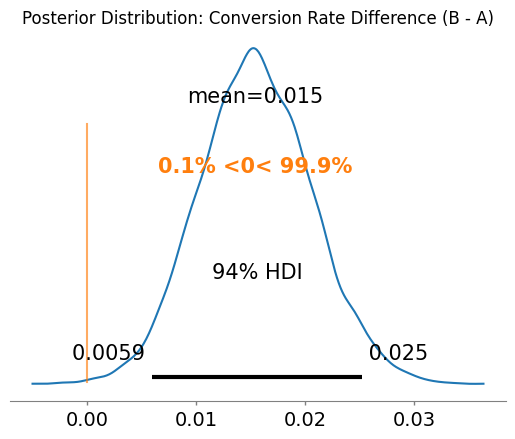

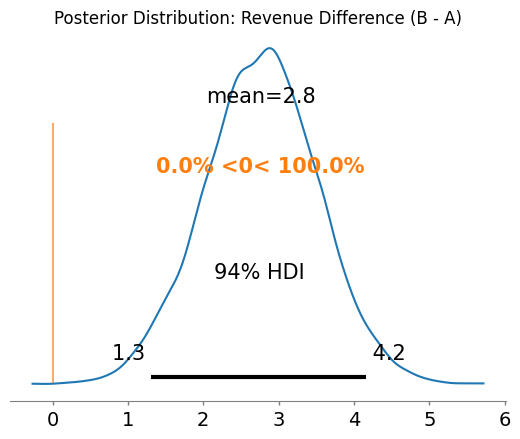

In [23]:
# Conversion data
conv_A = analysis_df.loc[analysis_df['variant'] == 'A', 'converted'].values
conv_B = analysis_df.loc[analysis_df['variant'] == 'B', 'converted'].values

# Revenue data
rev_A = analysis_df.loc[analysis_df['variant'] == 'A', 'revenue'].values
rev_B = analysis_df.loc[analysis_df['variant'] == 'B', 'revenue'].values

# --- 1. Conversion Rate Model (Bernoulli + Beta) ---
with pm.Model() as model_conv:
    alpha_prior, beta_prior = 1, 1
    p_A = pm.Beta('p_A', alpha_prior, beta_prior)
    p_B = pm.Beta('p_B', alpha_prior, beta_prior)

    obs_A = pm.Bernoulli('obs_A', p_A, observed=conv_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed=conv_B)

    diff_conv = pm.Deterministic('diff_conv', p_B - p_A)
    trace_conv = pm.sample(5000, tune=1000, random_seed=42, progressbar=False)

# --- 2. Revenue Model (Normal + weak priors) ---
with pm.Model() as model_rev:
    mu_A = pm.Normal('mu_A', mu=0, sigma=100)
    mu_B = pm.Normal('mu_B', mu=0, sigma=100)
    sigma_A = pm.HalfNormal('sigma_A', sigma=10)
    sigma_B = pm.HalfNormal('sigma_B', sigma=10)

    obs_A = pm.Normal('obs_A', mu_A, sigma_A, observed=rev_A)
    obs_B = pm.Normal('obs_B', mu_B, sigma_B, observed=rev_B)

    diff_rev = pm.Deterministic('diff_rev', mu_B - mu_A)
    trace_rev = pm.sample(5000, tune=1000, random_seed=42, progressbar=False)

# --- 3. Calculate probabilities & credible intervals ---
prob_B_better_conv = (trace_conv.posterior["diff_conv"] > 0).mean().item()
prob_B_better_rev = (trace_rev.posterior["diff_rev"] > 0).mean().item()

hdi_conv = az.hdi(trace_conv.posterior["diff_conv"], hdi_prob=0.94).to_array().values.flatten()
hdi_rev = az.hdi(trace_rev.posterior["diff_rev"], hdi_prob=0.94).to_array().values.flatten()

print(f"Pr(B > A) [Conversion Rate]: {prob_B_better_conv:.3f}, 94% HDI = [{hdi_conv[0]:.4f}, {hdi_conv[1]:.4f}]")
print(f"Pr(B > A) [Revenue]: {prob_B_better_rev:.3f}, 94% HDI = [{hdi_rev[0]:.2f}, {hdi_rev[1]:.2f}]")

# --- 4. Plot posterior distributions ---
az.plot_posterior(trace_conv, var_names=['diff_conv'], ref_val=0, hdi_prob=0.94)
plt.title("Posterior Distribution: Conversion Rate Difference (B - A)")
plt.show()

az.plot_posterior(trace_rev, var_names=['diff_rev'], ref_val=0, hdi_prob=0.94)
plt.title("Posterior Distribution: Revenue Difference (B - A)")
plt.show()


### Bayesian Inference – Interpretation

Unlike the frequentist tests, which only tell us whether we can reject the null hypothesis, the Bayesian approach provides a direct probability that one variant performs better than the other.

Conversion Rate:
The posterior mean difference between Variant B and Variant A is +1.5 pp, with a 94% HDI (Highest Density Interval) of [0.006, 0.025].
This means we can be 94% confident that the true lift in conversion lies between 0.6 % and 2.5 %.
The probability that Variant B (Free Delivery) outperforms Variant A (15 % Discount) is 99.9 % (Pr = 0.999) - a very strong signal.

Revenue per User:
The posterior mean difference is +€2.8, with a 94% HDI of [€1.3, €4.2].
The probability that Variant B yields higher revenue is effectively 100 % (Pr ≈ 1.000).
This confirms that the “Free Delivery” strategy not only improves conversions but also drives significantly higher customer value.

Interpretation:
Both metrics show that the effect of Variant B is positive and credible across almost the entire posterior distribution.
While frequentist tests already found statistical significance, the Bayesian analysis adds interpretability:

“There is a 99–100 % probability that Free Delivery outperforms the 15 % Discount campaign.”

This provides strong, decision-ready evidence supporting Variant B.

# Business Impact & Sensitivity Analysis

Goal: Translate statistical lift into profit per user and test whether the business decision is robust under realistic changes in costs and margins.

Profit model (per user):

Profit = Revenue * Gross Margin - Discount Cost + Waived Shipping Fee

We report:
- Baseline profit per user (e.g., gross margin = 40%).
- A sensitivity grid varying gross margin (30–50%) and shipping cost multiplier (0.8×–1.2×).
- Optional: a bootstrap 95% CI for the profit difference (B–A) at baseline.


=== Baseline Business Impact (gross margin = 40%) ===


,revenue,promo_cost,profit_per_user,Δ profit vs A
variant,,,,
A,20.02,1.51,6.50,0.00
B,22.80,0.60,8.52,2.02



=== Sensitivity Analysis: Profit per User (B–A) across margins & shipping costs ===


,gross_margin,shipping_mult,profit_A,profit_B,diff_B_minus_A
0,0.3,0.8,4.5,6.36,1.86
1,0.3,1.0,4.5,6.24,1.74
2,0.3,1.2,4.5,6.12,1.62
3,0.4,0.8,6.5,8.64,2.14
4,0.4,1.0,6.5,8.52,2.02
5,0.4,1.2,6.5,8.40,1.90
6,0.5,0.8,8.5,10.92,2.42
7,0.5,1.0,8.5,10.80,2.30
8,0.5,1.2,8.5,10.68,2.18


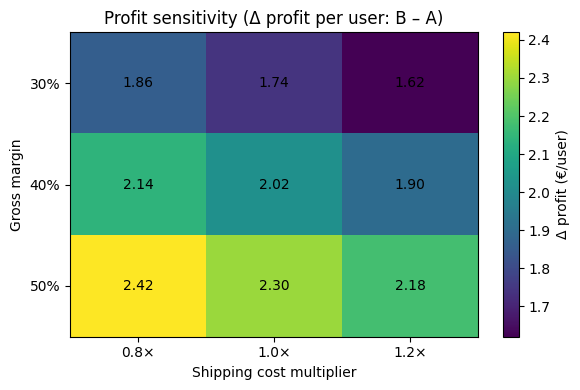


=== Baseline profit difference (B–A) with 95% bootstrap CI (margin=40%, ship×1.0) ===
Δ profit per user = 2.02 €  (95% CI: 1.46 … 2.55)


In [27]:
# -------------------------------
# 1) Baseline Business Impact
# -------------------------------

BASE_MARGIN = 0.40  # 40% gross margin

# Compute promo cost and profit per user at baseline
df_bi = analysis_df.copy()
df_bi["promo_cost"] = df_bi["discount_cost"] + df_bi["shipping_fee_waived"]
df_bi["profit_per_user"] = (df_bi["revenue"] * BASE_MARGIN) - df_bi["promo_cost"]

baseline_summary = (
    df_bi.groupby("variant")[["revenue", "promo_cost", "profit_per_user"]]
    .mean()
    .round(2)
)
baseline_summary["Δ profit vs A"] = baseline_summary["profit_per_user"] - baseline_summary.loc["A", "profit_per_user"]

print("=== Baseline Business Impact (gross margin = 40%) ===")
display(baseline_summary)

# -------------------------------
# 2) Sensitivity Grid
# -------------------------------

margins = [0.30, 0.40, 0.50]        # gross margin scenarios
ship_multipliers = [0.8, 1.0, 1.2]  # shipping cost multipliers (e.g., +20% shipping)

def avg_profit_by_variant(df, margin, ship_mult):
    """Return mean profit per user by variant for given margin & shipping multiplier."""
    tmp = df.copy()
    tmp["promo_cost"] = tmp["discount_cost"] + ship_mult * tmp["shipping_fee_waived"]
    tmp["profit"] = (tmp["revenue"] * margin) - tmp["promo_cost"]
    return tmp.groupby("variant")["profit"].mean()

rows = []
for m, s in itertools.product(margins, ship_multipliers):
    prof = avg_profit_by_variant(analysis_df, margin=m, ship_mult=s)
    rows.append({
        "gross_margin": m,
        "shipping_mult": s,
        "profit_A": prof["A"],
        "profit_B": prof["B"],
        "diff_B_minus_A": prof["B"] - prof["A"]
    })

sens_df = pd.DataFrame(rows).round(2)
print("\n=== Sensitivity Analysis: Profit per User (B–A) across margins & shipping costs ===")
display(sens_df)

# -------------------------------
# 3) Optional Heatmap (Δ profit B–A)
#    Tip: only include the most useful visuals in the final README.
# -------------------------------

# pivot table for plotting
pivot = sens_df.pivot(index="gross_margin", columns="shipping_mult", values="diff_B_minus_A")

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(pivot.values, aspect="auto")
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels([f"{c:.1f}×" for c in pivot.columns])
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels([f"{r:.0%}" for r in pivot.index])
ax.set_xlabel("Shipping cost multiplier")
ax.set_ylabel("Gross margin")
ax.set_title("Profit sensitivity (Δ profit per user: B – A)")

# annotate cells
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        ax.text(j, i, f"{pivot.values[i, j]:.2f}", ha="center", va="center")

fig.colorbar(im, ax=ax, label="Δ profit (€/user)")
plt.tight_layout()
plt.show()

# -------------------------------
# 4) Optional: Bootstrap CI for baseline Δ profit (B–A)
#    Gives an uncertainty interval around the business impact at baseline settings.
# -------------------------------

def bootstrap_diff_ci(df, margin=0.40, ship_mult=1.0, n_boot=2000, alpha=0.05, seed=7):
    rng = np.random.default_rng(seed)
    tmp = df.copy()
    tmp["promo_cost"] = tmp["discount_cost"] + ship_mult * tmp["shipping_fee_waived"]
    tmp["profit"] = (tmp["revenue"] * margin) - tmp["promo_cost"]

    a = tmp[tmp["variant"]=="A"]["profit"].values
    b = tmp[tmp["variant"]=="B"]["profit"].values

    diffs = np.empty(n_boot)
    na, nb = len(a), len(b)
    for k in range(n_boot):
        bs_a = a[rng.integers(0, na, na)]
        bs_b = b[rng.integers(0, nb, nb)]
        diffs[k] = bs_b.mean() - bs_a.mean()

    lo, hi = np.quantile(diffs, [alpha/2, 1 - alpha/2])
    return diffs.mean(), lo, hi

mean_diff, lo_diff, hi_diff = bootstrap_diff_ci(analysis_df, margin=BASE_MARGIN, ship_mult=1.0)
print(f"\n=== Baseline profit difference (B–A) with 95% bootstrap CI (margin=40%, ship×1.0) ===")
print(f"Δ profit per user = {mean_diff:.2f} €  (95% CI: {lo_diff:.2f} … {hi_diff:.2f})")

### Interpretation – Business Impact & Sensitivity

At baseline assumptions (40 % gross margin, normal shipping cost), Variant B (Free Delivery) generates
€2.02 higher profit per user than Variant A (15 % Discount).
This confirms that the winning variant is not only statistically stronger but also financially superior.

The sensitivity analysis stress-tests this result across realistic operational scenarios:

When gross margins drop to 30 %, the incremental profit shrinks but remains positive (+€1.6 – €1.9 / user).

Even if shipping costs increase by 20 %, Variant B continues to outperform.

At higher margins (50 %), the profit advantage grows up to +€2.4 / user.

Across all tested conditions, the sign of Δ profit stays consistently positive, indicating a robust business case for rolling out the Free Delivery promotion.

# Business Summary & Decision

| **Method / Analysis**        | **Metric**                 | **Variant A (15% Discount)** | **Variant B (Free Delivery)** | **Effect (B–A)**     | **Significance / CI / HDI**                    | **Interpretation**                                |
| ---------------------------- | -------------------------- | ---------------------------- | ----------------------------- | -------------------- | ---------------------------------------------- | ------------------------------------------------- |
| **Frequentist (z-test)**     | Conversion Rate            | 20.27%                       | 21.82%                        | **+1.55 pp**         | z = -3.00, p = 0.0027                          | Statistically significant lift in conversion      |
| **Frequentist (t-test)**     | Revenue per User (€)       | 20.02                        | 22.80                         | **+2.78 €**          | t = -3.68, p = 0.0002                          | Statistically significant increase in revenue     |
| **CUPED (variance-reduced)** | Conversion Rate            | 0.2036                       | 0.2173                        | **+1.37 pp**         | p = 0.0051                                     | Effect remains significant; confirms robustness   |
| **CUPED (variance-reduced)** | Revenue per User (€)       | 20.10                        | 22.72                         | **+2.62 €**          | p = 0.0004                                     | Stable effect after adjusting for pre-periods     |
| **Bayesian Inference**       | Conversion Rate            | —                            | —                             | **+1.5 pp**          | Pr(B > A) = **99.9%**, 94% HDI [0.0059, 0.025] | Very high posterior certainty that B > A          |
| **Bayesian Inference**       | Revenue per User (€)       | —                            | —                             | **+2.8 €**           | Pr(B > A) = **100%**, 94% HDI [1.3, 4.2]       | Practically certain lift in average revenue       |
| **Segmented Analysis**       | Cluster 1 (Regular Buyers) | +3.2 pp CR, +€7.3 Rev        | —                             | Strong positive lift | 95% CI excludes 0                              | Segment reacts best to B                          |
| **Business Impact**          | Profit per User (€)        | 6.50                         | 8.52                          | **+2.02 €**          | —                                              | Free Delivery yields higher profit                |
| **Sensitivity Analysis**     | Profit robustness          | —                            | —                             | +€1.6 to +€2.4       | across 30–50% margin & ±20% shipping           | Profit advantage remains stable across conditions |


### Summary
Across all analytical frameworks - frequentist, CUPED, Bayesian, and segment-level - the Free Delivery variant (B) consistently outperforms the 15% Discount variant (A) in both conversion rate and revenue per user.
The effect is statistically significant (p < 0.01), robust after CUPED adjustment, and supported by a near-100% Bayesian probability that B > A.

Even when tested under less favorable business assumptions (lower margin or higher shipping costs), Free Delivery maintains a positive and meaningful profit lift of +€1.6–2.4 per user.

### Decision Recommendation
Implement Free Delivery as the new standard promotion.
It drives higher conversions, greater average revenue, and improved profitability, while remaining resilient across operational changes.

### Optional next steps

Monitor real-world rollout for confirmation over multiple cycles (replication).
Test combined offers (e.g., tiered free shipping thresholds or loyalty-based delivery perks).

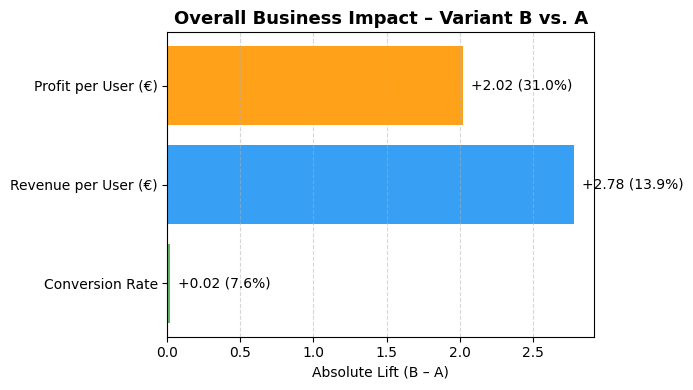

In [39]:
# Core metrics and their lifts based on your results
metrics = ['Conversion Rate', 'Revenue per User (€)', 'Profit per User (€)']
lifts = [0.0155, 2.78, 2.02]  # absolute lifts (B - A)
rel_lifts = [7.6, 13.9, 31.0]  # relative (%), optional for annotation
colors = ['#4CAF50', '#2196F3', '#FF9800']

fig, ax = plt.subplots(figsize=(7,4))
bars = ax.barh(metrics, lifts, color=colors, alpha=0.9)

# Annotate each bar with the effect size and relative change
for i, (v, rel) in enumerate(zip(lifts, rel_lifts)):
    ax.text(v + max(lifts)*0.02, i, f"+{v:.2f} ({rel:.1f}%)", va='center', fontsize=10)

# Labels and formatting
ax.set_title("Overall Business Impact – Variant B vs. A", fontsize=13, weight='bold')
ax.set_xlabel("Absolute Lift (B – A)")
ax.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Limitations & Next Steps

While the experiment demonstrates robust statistical and business evidence,  
several extensions could further strengthen confidence in real-world deployment:

1. Replication: Re-run the experiment in a different time window or region to verify stability of results.  
2. Sensitivity Enhancements: Test robustness under additional scenarios such as higher refund rates or customer churn.  
3. Sequential Testing: Introduce controlled interim checks (alpha-spending) for faster learning in production environments.  
4. Extended Guardrails: In a real setup, monitor unsubscribe and refund rates to ensure a sustainable user experience.  
5. Integration with CRM Data: Combine experimental results with long-term customer value (LTV) data to assess downstream effects.

These extensions would not necessarily change the conclusion, but would increase the credibility and external validity of the findings.
